In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import datetime

# Librerias para constuir la arquitectura U-Net
from tensorflow.keras.layers import Input, Lambda, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

In [ ]:
import os
import numpy as np
from tqdm import tqdm
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt

# Librerías para construir la arquitectura U-Net
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
import datetime


In [ ]:
# Tamaño de las imágenes
height_shape, width_shape = 128, 128
batch_size = 16
epochs = 400

# Rutas proporcionadas
data_path_train_images = "/content/drive/MyDrive/TESIS/UNET/data_split/train/images"
data_path_train_masks = "/content/drive/MyDrive/TESIS/UNET/data_split/train/masks"

data_path_valid_images = "/content/drive/MyDrive/TESIS/UNET/data_split/valid/images"
data_path_valid_masks = "/content/drive/MyDrive/TESIS/UNET/data_split/valid/masks"

data_path_test_images = "/content/drive/MyDrive/TESIS/UNET/data_split/test/images"
data_path_test_masks = "/content/drive/MyDrive/TESIS/UNET/data_split/test/masks"


In [ ]:
def load_data(image_path, mask_path):
    images, masks = [], []

    # Cargar imágenes
    for img_file in tqdm(sorted(os.listdir(image_path))):
        img_path = os.path.join(image_path, img_file)
        img = imread(img_path)[:,:,:3]  # Leer como RGB
        img = resize(img, (height_shape, width_shape), mode='constant', preserve_range=True)
        images.append(img)

    # Cargar máscaras
    for mask_file in tqdm(sorted(os.listdir(mask_path))):
        mask_path_full = os.path.join(mask_path, mask_file)
        mask_img = imread(mask_path_full)
        mask_img = resize(mask_img, (height_shape, width_shape), mode='constant', preserve_range=True)

        if len(mask_img.shape) == 3:  # Si tiene tres canales, convertir a escala de grises
            mask_img = mask_img[:, :, 0]

        mask_img = np.expand_dims(mask_img, axis=-1)  # Agregar un canal
        masks.append(mask_img)

    # Convertimos a numpy arrays
    return np.array(images, dtype=np.uint8), np.array(masks, dtype=np.bool_)




In [ ]:
# Cargar datos
X_train, Y_train = load_data(data_path_train_images, data_path_train_masks)
X_valid, Y_valid = load_data(data_path_valid_images, data_path_valid_masks)
X_test, Y_test = load_data(data_path_test_images, data_path_test_masks)

# Imprimir formas de los datos
print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"Y_valid shape: {Y_valid.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")



100%|██████████| 6/6 [00:02<00:00,  2.46it/s]

X_train shape: (77, 128, 128, 3)
Y_train shape: (77, 128, 128, 1)
X_valid shape: (28, 128, 128, 3)
Y_valid shape: (28, 128, 128, 1)
X_test shape: (6, 128, 128, 3)
Y_test shape: (6, 128, 128, 1)


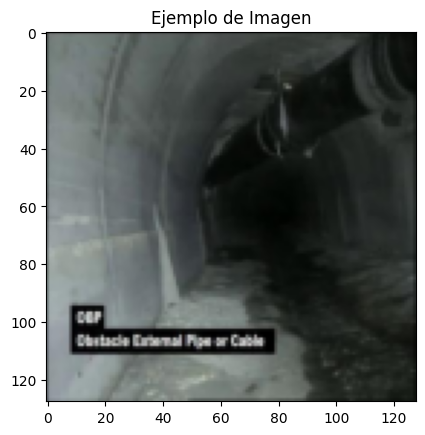

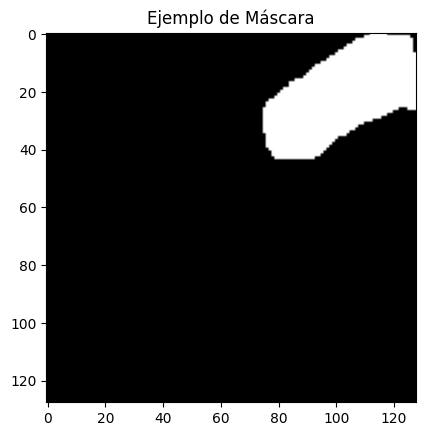

In [ ]:
# Mostrar una imagen y su máscara asociada
plt.imshow(X_train[0])
plt.title("Ejemplo de Imagen")
plt.show()

plt.imshow(np.squeeze(Y_train[0]), cmap="gray")
plt.title("Ejemplo de Máscara")
plt.show()


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, Lambda
from tensorflow.keras.models import Model

# Normalizar los valores de entrada
inputs = Lambda(lambda x: x / 255)(Input((128, 128, 3)))

# Contracting Path
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Dropout(0.1)(conv1)
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
maxp1 = MaxPooling2D((2, 2))(conv1)

conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(maxp1)
conv2 = Dropout(0.1)(conv2)
conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
maxp2 = MaxPooling2D((2, 2))(conv2)

conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(maxp2)
conv3 = Dropout(0.2)(conv3)
conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
maxp3 = MaxPooling2D((2, 2))(conv3)

conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(maxp3)
conv4 = Dropout(0.2)(conv4)
conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
maxp4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(maxp4)
conv5 = Dropout(0.3)(conv5)
conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

# Expansive Path
up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5)
up6 = concatenate([up6, conv4])
conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
conv6 = Dropout(0.2)(conv6)
conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
up7 = concatenate([up7, conv3])
conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
conv7 = Dropout(0.2)(conv7)
conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
up8 = concatenate([up8, conv2])
conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
conv8 = Dropout(0.1)(conv8)
conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
up9 = concatenate([up9, conv1])
conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
conv9 = Dropout(0.1)(conv9)
conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

# Definir el modelo
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor_3CLONE       │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          1,792 │ keras_tensor_3CLONE[1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 64)   │              0 │ conv2d[1][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ dropout[1][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ conv2d_1[1][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[1][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64, 64, 128)    │              0 │ conv2d_2[1][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ dropout_1[1][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ conv2d_3[1][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[1][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 32, 32, 256)    │              0 │ conv2d_4[1][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ dropout_2[1][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 256)    │              0 │ conv2d_5[1][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_2[1][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 16, 16, 512)    │              0 │ conv2d_6[1][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 512)    │      2,359,808 │ dropout_3[1][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 8, 8, 512)      │              0 │ conv2d_7[1][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/400
5/5 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - accuracy: 0.6533 - loss: 3.6261 - val_accuracy: 0.1852 - val_loss: 2.6421
Epoch 2/400
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5880 - loss: 1.5325 - val_accuracy: 0.8585 - val_loss: 1.2825
Epoch 3/400
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8859 - loss: 0.7928 - val_accuracy: 0.8578 - val_loss: 0.6006
Epoch 4/400
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8386 - loss: 0.5126 - val_accuracy: 0.8583 - val_loss: 0.4499
Epoch 5/400
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8734 - loss: 0.4490 - val_accuracy: 0.8584 - val_loss: 0.4526
Epoch 6/400
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8716 - loss: 0.4443 - val_accuracy: 0.8584 - val_loss: 0.4807
Epoch 7/400
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8805 - loss: 0.4207 - val_accuracy: 0.8584 - val_loss: 0.4591
Epoch 8/400
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8747 - loss: 0.4176 - val_accuracy: 0.8585 - val_loss: 

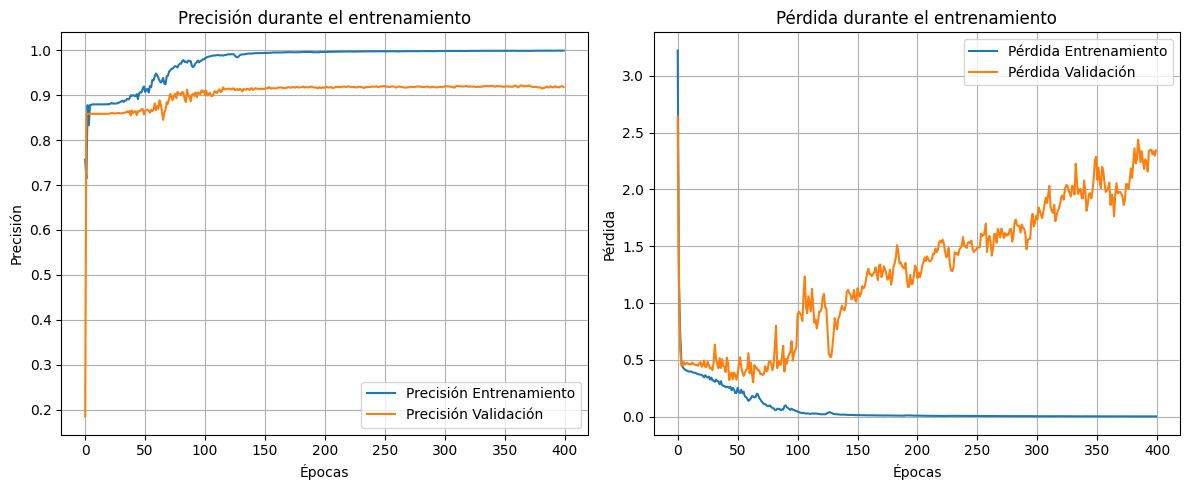

In [ ]:
# Entrenamiento del modelo
history = model.fit(
    X_train, Y_train,
    validation_data=(X_valid, Y_valid),  # Usamos el conjunto de validación separado
    batch_size=batch_size,              # Tamaño del lote definido previamente
    epochs=epochs,                      # Número de épocas definido previamente
    verbose=1                           # Muestra el progreso del entrenamiento
)

# Evaluar el modelo en el conjunto de prueba
test_results = model.evaluate(X_test, Y_test, verbose=1)
print("Resultados del conjunto de prueba:", test_results)


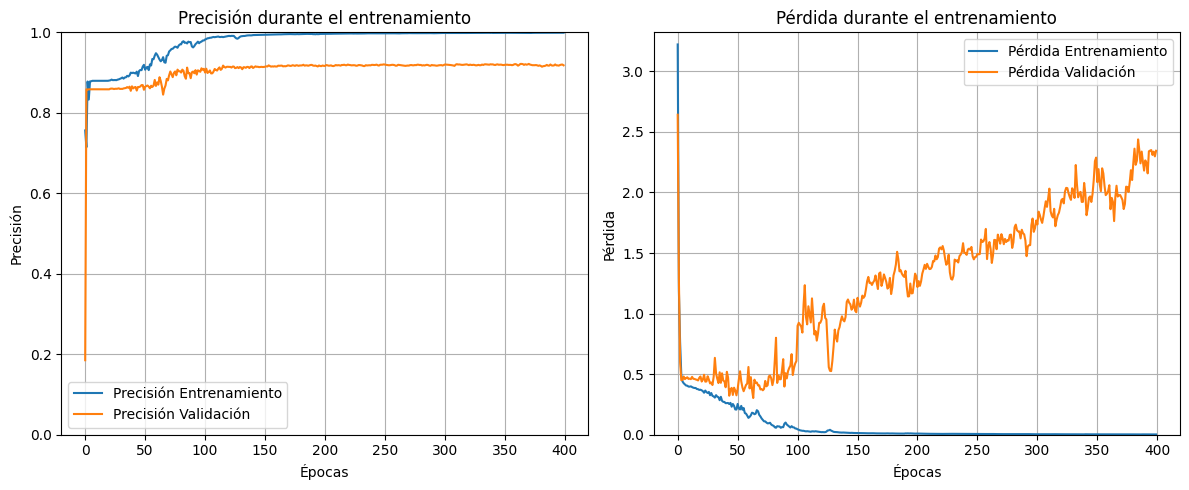

In [ ]:
import matplotlib.pyplot as plt

def plot_training_metrics(history):
    """
    Función para graficar las métricas de entrenamiento y validación con ejes ajustados desde 0.
    """
    # Obtener las métricas del historial
    train_accuracy = history.history.get('accuracy', [])
    val_accuracy = history.history.get('val_accuracy', [])
    train_loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])

    # Graficar precisión
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracy, label='Precisión Entrenamiento')
    plt.plot(val_accuracy, label='Precisión Validación')
    plt.title('Precisión durante el entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.ylim(0, 1)  # Ajustar el eje y desde 0 a 1
    plt.legend()
    plt.grid(True)

    # Graficar pérdida
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Pérdida Entrenamiento')
    plt.plot(val_loss, label='Pérdida Validación')
    plt.title('Pérdida durante el entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.ylim(0, max(max(train_loss), max(val_loss)) + 0.1)  # Ajustar el eje y para mostrar desde 0
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Llamar a la función para graficar las métricas de entrenamiento
plot_training_metrics(history)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


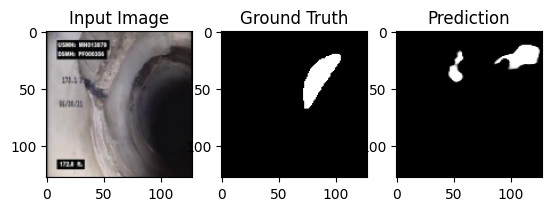

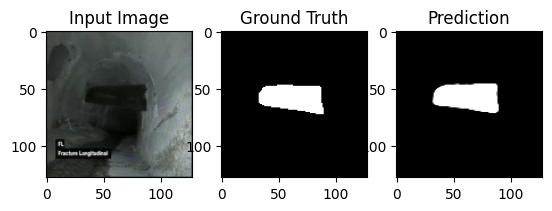

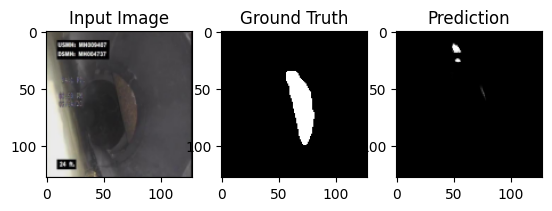

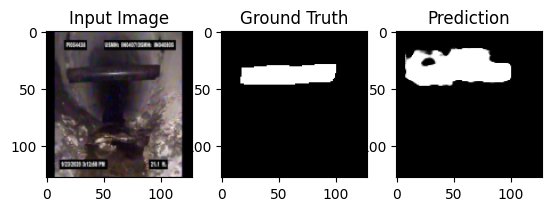

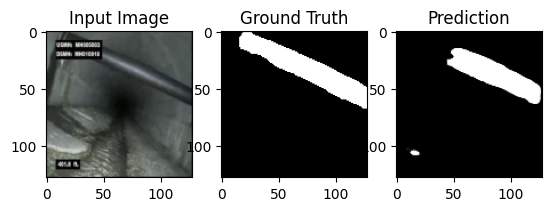

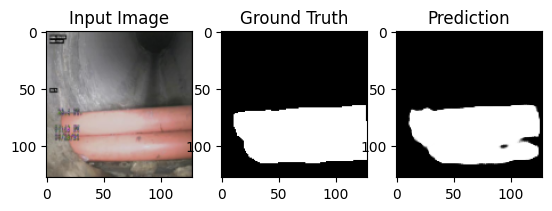

In [ ]:
preds = model.predict(X_test)
for i in range(len(preds)):
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(X_test[i])
    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.imshow(Y_test[i].squeeze(), cmap='gray')
    plt.subplot(1, 3, 3)
    plt.title("Prediction")
    plt.imshow(preds[i].squeeze(), cmap='gray')
    plt.show()
